In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from IPython.display import display, HTML
from typing import NamedTuple, List
import math

### Gaussian Bandit Environment

In [2]:
class GaussianArm(NamedTuple):
  mean: float
  std: float


class Env:
  def __init__(self, num_arms: int, mean_reward_range: tuple, std: float):
    """
    num_arms: number of bandit arms
    mean_reward_range: mean reward of an arm should lie between the given range
    std: standard deviation of the reward for each arm
    """
    self.num_arms = num_arms
    self.arms = self.create_arms(num_arms, mean_reward_range, std)

  def create_arms(self, n: int, mean_reward_range: tuple, std: float) -> dict:
    low_rwd, high_rwd = mean_reward_range
    # creates "n" number of mean reward for each arm
    means = np.random.uniform(low=low_rwd, high=high_rwd, size=(n,))
    arms = {id: GaussianArm(mu, std) for id, mu in enumerate(means)}
    return arms

  @property
  def arm_ids(self):
    return list(self.arms.keys())

  def step(self, arm_id: int) -> float:
    arm = self.arms[arm_id]
    return np.random.normal(arm.mean, arm.std)   # Reward

  def get_best_arm_and_expected_reward(self):
    best_arm_id = max(self.arms, key=lambda x: self.arms[x].mean)
    return best_arm_id, self.arms[best_arm_id].mean

  def get_avg_arm_reward(self):
    arm_mean_rewards = [v.mean for v in self.arms.values()]
    return np.mean(arm_mean_rewards)

  def plot_arms_reward_distribution(self, num_samples=1000):
    """
    This function is only used to visualize the arm's distrbution.
    """
    fig, ax = plt.subplots(1, 1, sharex=False, sharey=False, figsize=(9, 5))
    colors = sns.color_palette("hls", self.num_arms)
    for i, arm_id in enumerate(self.arm_ids):
      reward_samples = [self.step(arm_id) for _ in range(num_samples)]
      sns.histplot(reward_samples, ax=ax, stat="density", kde=True, bins=100, color=colors[i], label=f'arm_{arm_id}')
    ax.legend()
    plt.show()

### Policy

In [3]:
class BasePolicy:
  @property
  def name(self):
    return 'base_policy'

  def reset(self):
    """
    This function resets the internal variable.
    """
    pass

  def update_arm(self, *args):
    """
    This function keep track of the estimates
    that we may want to update during training.
    """
    pass

  def select_arm(self) -> int:
    """
    It returns arm_id
    """
    raise Exception("Not Implemented")

#### Random Policy

In [4]:
class RandomPolicy(BasePolicy):
  def __init__(self, arm_ids: List[int]):
    self.arm_ids = arm_ids

  @property
  def name(self):
    return 'random'

  def reset(self) -> None:
    """No use."""
    pass

  def update_arm(self, *args) -> None:
    """No use."""
    pass

  def select_arm(self) -> int:
    return np.random.choice(self.arm_ids)

In [5]:
class EpGreedyPolicy(BasePolicy):
  def __init__(self, epsilon: float, arm_ids: List[int]):
    self.epsilon = epsilon
    self.arm_ids = arm_ids
    self.Q = {id: 0 for id in self.arm_ids}
    self.num_pulls_per_arm = {id: 0 for id in self.arm_ids}

  @property
  def name(self):
    return f'ep-greedy ep:{self.epsilon}'

  def reset(self) -> None:
    self.Q = {id: 0 for id in self.arm_ids}
    self.num_pulls_per_arm = {id: 0 for id in self.arm_ids}

  def update_arm(self, arm_id: int, arm_reward: float) -> None:
    self.num_pulls_per_arm[arm_id] += 1
    self.Q[arm_id] = self.Q[arm_id] + (arm_reward - self.Q[arm_id]) / (self.num_pulls_per_arm[arm_id]) 

  def select_arm(self) -> int:
    best_arm = max(self.Q, key=lambda x: self.Q[x])
    probabilities = {id:self.epsilon / len(self.arm_ids) for id in self.arm_ids}
    probabilities[best_arm] += 1 - self.epsilon
    return np.random.choice(self.arm_ids, p=list(probabilities.values()))

In [20]:
class SoftmaxPolicy(BasePolicy):
  def __init__(self, tau : float, arm_ids:List[int]):
    self.tau = tau
    self.arm_ids = arm_ids
    self.Q = {id: 0 for id in self.arm_ids}
    self.num_pulls_per_arm = {id: 0 for id in self.arm_ids}

  @property
  def name(self):
    return f'softmax tau:{self.tau}'

  def reset(self):
    self.Q = {id: 0 for id in self.arm_ids}
    self.num_pulls_per_arm = {id: 0 for id in self.arm_ids}

  def update_arm(self, arm_id: int, arm_reward: float) -> None:
    self.num_pulls_per_arm[arm_id] += 1
    self.Q[arm_id] = self.Q[arm_id] + (arm_reward - self.Q[arm_id]) / (self.num_pulls_per_arm[arm_id]) 

  def select_arm(self) -> int:
    max_q = max(self.Q.values())
    exp_values = np.array([np.exp((q - max_q) / self.tau) for q in self.Q.values()])
    sum_exps = exp_values.sum()
    probabilities = {id: exp_val / sum_exps for id, exp_val in zip(self.arm_ids, exp_values)}
    if sum(probabilities.values()) != 1:
      return max(self.Q, key=lambda x: self.Q[x])
    return np.random.choice(self.arm_ids, p=list(probabilities.values()))

In [35]:
class UCB(BasePolicy):
  def __init__(self,c:float, env):  
    self.c = c
    self.env = env
    self.arm_ids = self.env.arm_ids
    self.Q = {id: self.env.step(id) for id in self.arm_ids}
    self.num_pulls_per_arm = {id: 1 for id in self.arm_ids}

  @property
  def name(self):
    return f'UCB c:{self.c}'

  def reset(self):
    self.Q = {id: self.env.step(id) for id in self.arm_ids}
    self.num_pulls_per_arm = {id: 1 for id in self.arm_ids}

  def update_arm(self, arm_selected: int, arm_reward: float):
    self.num_pulls_per_arm[arm_selected] += 1
    self.Q[arm_selected] = self.Q[arm_selected] + (arm_reward - self.Q[arm_selected])/self.num_pulls_per_arm[arm_selected]


  def select_arm(self) -> int:
    number_of_pulls = sum(self.num_pulls_per_arm.values())
    try :
      selected_arm = max(self.Q,key = lambda x : self.Q[x] + self.c*(np.sqrt(np.log(number_of_pulls)/(self.num_pulls_per_arm[x]))))
    except RuntimeError:
      selected_arm = max(self.Q,key = lambda x : self.Q[x])
    return selected_arm

#### Trainer

In [33]:
def train(env, policy: BasePolicy, timesteps):
  policy_reward = np.zeros((timesteps,))
  for t in range(timesteps):
    arm_id = policy.select_arm()
    reward = env.step(arm_id)
    policy.update_arm(arm_id, reward)
    policy_reward[t] = reward
  return policy_reward


def avg_over_runs(env, policy: BasePolicy, timesteps, num_runs):
  _, expected_max_reward = env.get_best_arm_and_expected_reward()
  policy_reward_each_run = np.zeros((num_runs, timesteps))
  for run in range(num_runs):
    policy.reset()
    policy_reward = train(env, policy, timesteps)
    policy_reward_each_run[run, :] = policy_reward

  # calculate avg policy reward from policy_reward_each_run
  avg_policy_rewards = np.mean(policy_reward_each_run,axis=0) # your code here (type: nd.array, shape: (timesteps,))
  total_policy_regret = timesteps*expected_max_reward - np.sum(avg_policy_rewards)# your code here (type: float)

  return avg_policy_rewards, total_policy_regret

In [9]:
a = np.array([[1,2,3],[4,5,6]])
np.mean(a, axis=0)

array([2.5, 3.5, 4.5])

In [10]:
def plot_reward_curve_and_print_regret(env, policies, timesteps=200, num_runs=500):
  fig, ax = plt.subplots(1, 1, sharex=False, sharey=False, figsize=(10, 6))
  for policy in policies:
    avg_policy_rewards, total_policy_regret = avg_over_runs(env, policy, timesteps, num_runs)
    print('regret for {}: {:.3f}'.format(policy.name, total_policy_regret))
    ax.plot(np.arange(timesteps), avg_policy_rewards, '-', label=policy.name)

  _, expected_max_reward = env.get_best_arm_and_expected_reward()
  ax.plot(np.arange(timesteps), [expected_max_reward]*timesteps, 'g-')

  avg_arm_reward = env.get_avg_arm_reward()
  ax.plot(np.arange(timesteps), [avg_arm_reward]*timesteps, 'r-')

  plt.legend(loc='lower right')
  plt.show()

### Experiments

In [11]:
seed = 42
np.random.seed(seed)

num_arms = 5
mean_reward_range = (-25, 25)
std = 2.0

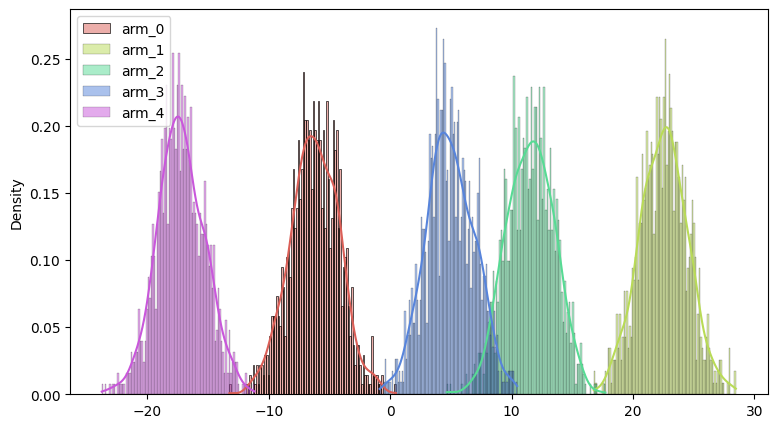

In [12]:
env = Env(num_arms, mean_reward_range, std)

env.plot_arms_reward_distribution()

In [13]:
best_arm, max_mean_reward = env.get_best_arm_and_expected_reward()
print(best_arm, max_mean_reward)

1 22.53571532049581


In [14]:
print(env.get_avg_arm_reward())

3.119254917081568


#### Please explore following values:

- Epsilon greedy: [0.001, 0.01, 0.5, 0.9]
- Softmax: [0.001, 1.0, 5.0, 50.0]

regret for random: 3871.625


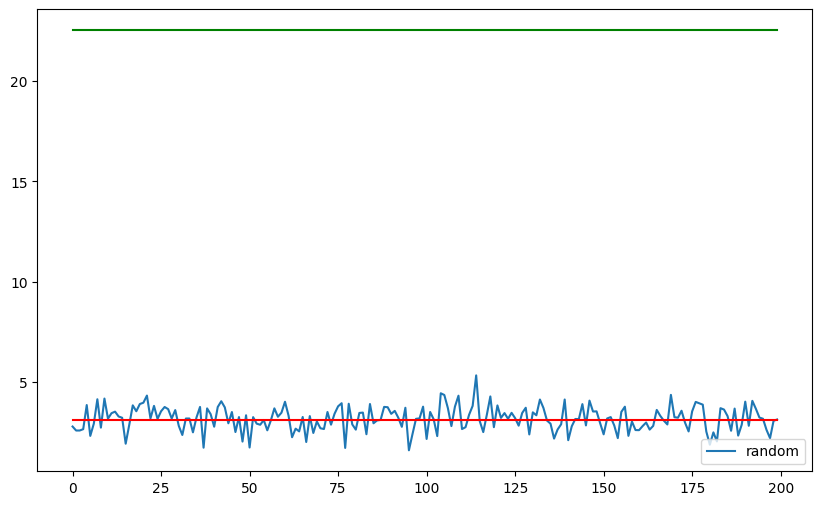

In [15]:
random_policy = RandomPolicy(env.arm_ids)
plot_reward_curve_and_print_regret(env, [random_policy], timesteps=200, num_runs=500)

regret for ep-greedy ep:0.001: 35.471
regret for ep-greedy ep:0.01: 77.678
regret for ep-greedy ep:0.5: 1987.793
regret for ep-greedy ep:0.9: 3503.219


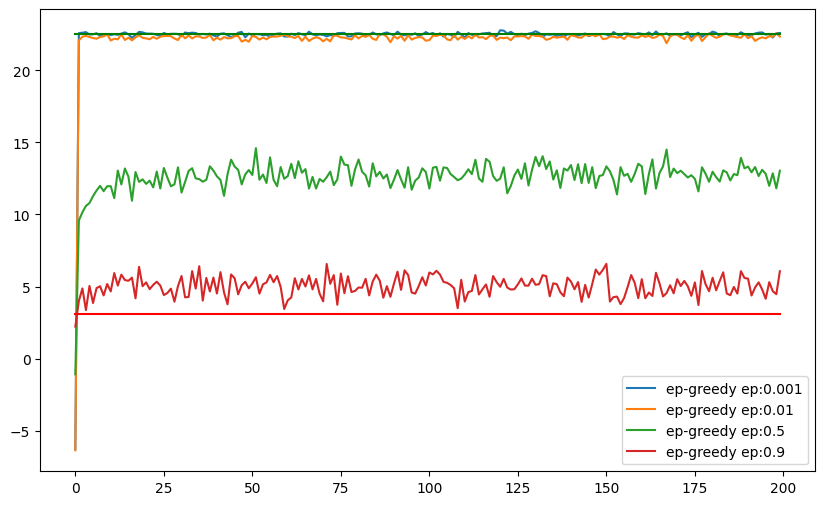

In [16]:
explore_epgreedy_epsilons =  [0.001, 0.01, 0.5, 0.9]
epgreedy_policies = [EpGreedyPolicy(ep, env.arm_ids) for ep in explore_epgreedy_epsilons]
plot_reward_curve_and_print_regret(env, epgreedy_policies, timesteps=200, num_runs=500)

regret for softmax tau:0.001: 1856.184
regret for softmax tau:1.0: 1297.500
regret for softmax tau:5.0: 274.256
regret for softmax tau:10.0: 711.473
regret for softmax tau:50.0: 2275.774


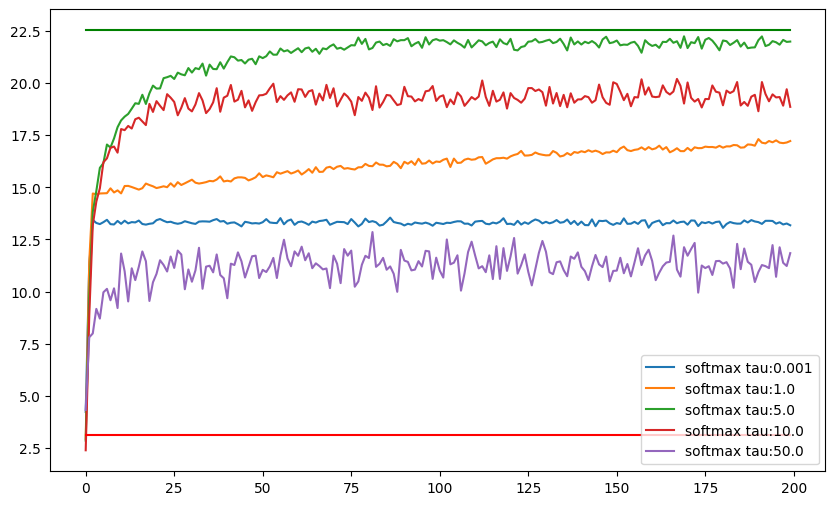

In [38]:
explore_softmax_taus =  [0.001, 1.0, 5.0, 10.0, 50.0]
softmax_polices = [SoftmaxPolicy(tau, env.arm_ids) for tau in explore_softmax_taus]
plot_reward_curve_and_print_regret(env, softmax_polices, timesteps=200, num_runs=500)

regret for UCB c:0.1: -0.839
regret for UCB c:1.0: -1.124
regret for UCB c:5.0: 4.477
regret for UCB c:10.0: 48.585
regret for UCB c:50.0: 1073.227


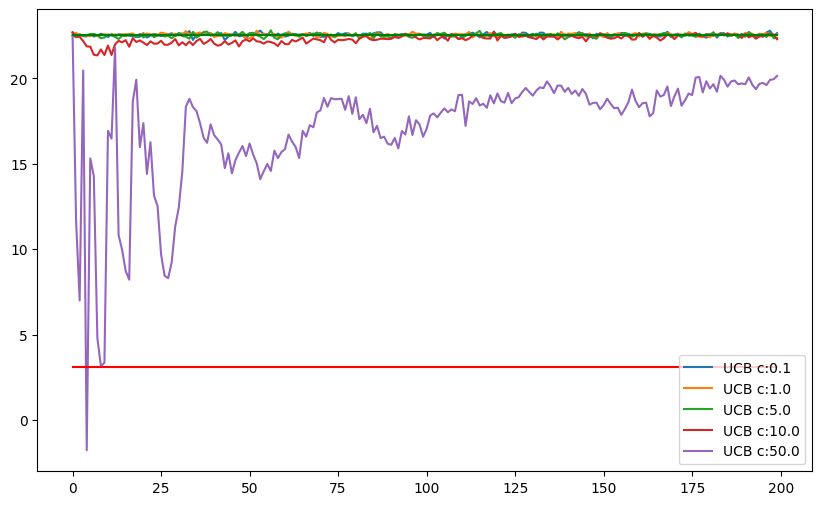

In [37]:
explore_softmax_cs =  [0.001,0.1, 1.0, 5.0, 10.0 ,50.0]
ucb_polices = [UCB(c, env) for c in explore_softmax_cs]
plot_reward_curve_and_print_regret(env, ucb_polices, timesteps=200, num_runs=500)

From the setting performance RandomPolicy<br>
UCB,SoftmaxPolicy and EpGreedyPolicy were tested and their performance was compared.Following are the conclusions<br><br>
<b>EpGreedyPolicy:</b><br>
<ul>
<li>As the value of &#949 increases, the expected returns has a high offset from the maximum reward giving arm.(Policy is to explore more than to exploit) </li>
<li>It is clearly visible from the above fact that regret increases with increase in value of &#949. </li>
</ul> 
<b>SoftmaxPolicy:</b><br>
<ul>
<li>As the value of &#916 increases, policy is less greedy, taking larger samples to choose maximum reward giving arm. </li>
<li>It is clearly visible from the above fact that regret increases with increase in value of &#916. </li>
</ul> 
<b>UCB (Upper Confidence Bound):</b><br>
<ul>
<li>As the value of c increases, allowing arms to more explore, it takes larger samples to select to choose maximum rewarding arm. </li>
<li>It is clearly visible from the above fact that regret increases with increase in value of c. </li>
</ul> 

## Generate PDF

In [ ]:
!pip install nbconvert

!jupyter nbconvert --to pdf /content/your_notebook_name.ipynb
# Replace 'your_notebook_name.ipynb' with the actual name of your notebook file.


This application is used to convert notebook files (*.ipynb)
        to various other formats.


Options
The options below are convenience aliases to configurable class-options,
as listed in the "Equivalent to" description-line of the aliases.
To see all configurable class-options for some <cmd>, use:
    <cmd> --help-all

--debug
    set log level to logging.DEBUG (maximize logging output)
    Equivalent to: [--Application.log_level=10]
--show-config
    Show the application's configuration (human-readable format)
    Equivalent to: [--Application.show_config=True]
--show-config-json
    Show the application's configuration (json format)
    Equivalent to: [--Application.show_config_json=True]
--generate-config
    generate default config file
    Equivalent to: [--JupyterApp.generate_config=True]
-y
    Answer yes to any questions instead of prompting.
    Equivalent to: [--JupyterApp.answer_yes=True]
--execute
    Execute the notebook prior to export.
    Equivalent to: [--ExecutePr

[NbConvertApp] WARNING | pattern 'C:/Users/aksha/OneDrive/Desktop/codes/CP/DA6400-Reinforcement-Learning/Tutorial' matched no files
[NbConvertApp] WARNING | pattern '1/DA6400_Tutorial_1_Bandits[1].ipynb' matched no files
